In [444]:
%pylab inline
import string

Populating the interactive namespace from numpy and matplotlib


/Users/zaf/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [446]:
def split(genomes, by):
    L = []
    R = []
    if len(genomes) == 1:
        return genomes, R
    for g in genomes:
        if by in g:
            L.append(g)
        else:
            R.append(g)
    return L, R

def prepare_snp_data(genomes):
    data = set(map(frozenset, [[-1]+g for g in genomes]))
    all_snps = Counter()
    [all_snps.update(data_) for data_ in data]
    return data, all_snps


In [479]:
class Node(object):
    def __init__(self, genomes, all_snps=None, snp_to_check=-1):
        self.genomes = genomes
        self.branch_length = 0
        self.resolved = False
        self.snp_to_check = snp_to_check
        self.all_snps = all_snps
        self.L = None
        self.R = None
        self.descendants = len(genomes)
#         print('CREATED NEW NODE:', genomes, snp_to_check)
        
    def resolve(self):
        if self.resolved:
            return
        if self.snp_to_check is None or self.all_snps is None:
            self.resolved=True
            return
        
        L, R = [], []
        while len(L) == 0 or len(R) == 0:
            if self.snp_to_check+1 >= len(self.all_snps):
                # run out of snps to check
                self.snp_to_check = None
                self.resolved = True
                # do nothing here. just exit
                return
            else:
                # increment the snp we are checking
                self.snp_to_check += 1
#             print('checking', self.all_snps[self.snp_to_check][0])
            # attempt to do a split
            L, R = split(self.genomes, self.all_snps[self.snp_to_check][0])
            if len(R) == 0 and len(L) != 0:
                # everyone is on the same branch
                # just increase the length of this one
                if self.all_snps[self.snp_to_check][0] in L[0]:
                    self.branch_length += 1
        
        # we exit this loop, this means that
        # we have an non trivial split.
        self.resolved = True

        # first deal with the left branch these are the ones that have.
        # avoid checking the same snp again so self.snp_to_check + 1
        self.L = Node(L, self.all_snps, self.snp_to_check)
        # increase the branch length because we know everyone on L
        # has this snp.
        self.L.branch_length += 1 
        self.R = Node(R, self.all_snps, self.snp_to_check)
        self.L.resolve()
        self.R.resolve()


    def represent_internals(self):
        if self.L is None and self.R is None:
            return str(self.genomes)
        else:
            return str(self.L) + ','+str(self.R)

    def __str__(self):
        return self.__repr__()
    def __repr__(self):
        start = '['
        end = ']'
        if self.resolved:
            start = '('
            end = ')'
        
        if self.L is None and self.R is None:
            start = ''
            end = ''
        
        return start + self.represent_internals() + end + ':' + str(self.branch_length)
    def assign_names(self, name_mapper):
        if self.L is None and self.R is None and len(self.genomes) == 1:
            self.genomes = name_mapper[self.genomes[0]]
        else:
            self.L.assign_names(name_mapper)
            self.R.assign_names(name_mapper)
            
    def plot(self, width, midpoint, top_start=0, ax=None):
        """ Plots the lineage and all its descending lineages. To avoid overlap when plotting
        multiple lineages, we specify the width and center of the lineage along the x-axis.
        Time is plotted along the y axis, and uses the lineage T0 and T1"""
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        branch_height = top_start-self.branch_length-1
        ax.plot([midpoint, midpoint], [top_start,branch_height], 'b') # Plot vertical lineage
        if not (self.L is None and self.R is None):
            # Assign width proportional to the number of lineages in each sub-lineage
            n1 = self.R.descendants
            n2 = self.L.descendants
            width_1 = n1 * 1./(n1+n2) * width
            width_2 = n2 * 1./(n1+n2) * width
            midpoint_1 = midpoint - width/2. + width_1/2.  # Find the midpoint of each window
            midpoint_2 = midpoint + width/2. - width_2/2.
            # Plot horizontal connector
            ax.plot([midpoint_1, midpoint_2], [branch_height, branch_height], 'b')                                                                               
            self.L.plot(width_1,midpoint_1, branch_height, ax)  # Plot descending lineages
            self.R.plot(width_2,midpoint_2, branch_height, ax) 

In [480]:
# TRIVIAL CASE?
nc = name_creator()
global nc
# data = [
#     [10, 20],
#     [10, 30, 40],
# #     [10, 30, 40, 50],
# ]
data = [
#     [10, 20, 50],
#     [10, 20, 40, 80],
    [10, 30, 60, 70, 80, 90],
    [10, 30]
]
from collections import Counter
data, all_snps = prepare_snp_data(data)
name_mapper = dict(zip(data, string.ascii_letters))
print(all_snps)
node = Node(data, all_snps.most_common())
print('unresolved:',node)
node.resolve()
node.assign_names(name_mapper)
print('resolved:',node)

Counter({10: 2, 30: 2, -1: 2, 70: 1, 80: 1, 90: 1, 60: 1})
('unresolved:', set([frozenset([10, 30, -1]), frozenset([70, 10, 80, -1, 90, 60, 30])]):0)
('resolved:', (b:4,a:0):3)


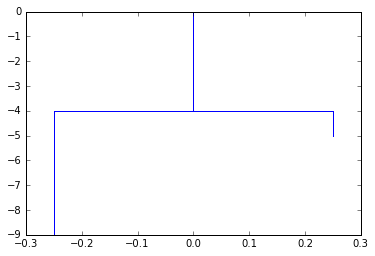

In [481]:
node.plot(1,0)

In [482]:
data = [
    [10, 20, 50],
    [10, 20, 40, 80],
    [10, 30, 60, 70],
    [10, 30]
]

In [483]:
nc = name_creator()
global nc
# data = [
#     [10, 20],
#     [10, 30, 40],
# #     [10, 30, 40, 50],
# ]
data = [
    [10, 20, 50],
    [10, 20, 40, 80],
    [10, 30, 60, 70],
    [10, 30]
]
from collections import Counter
all_snps = Counter()
data = set(map(frozenset, data))
_=[all_snps.update(data_) for data_ in data]
name_mapper = dict(zip(data, string.ascii_letters))
print(all_snps)
node = Node(data, all_snps.most_common())
print('unresolved:',node)
node.resolve()
node.assign_names(name_mapper)
print('resolved:',node)

Counter({10: 4, 20: 2, 30: 2, 70: 1, 40: 1, 80: 1, 50: 1, 60: 1})
('unresolved:', set([frozenset([10, 30]), frozenset([10, 20, 50]), frozenset([10, 60, 70, 30]), frozenset([40, 80, 10, 20])]):0)
('resolved:', ((d:2,b:1):1,(c:2,a:0):1):1)


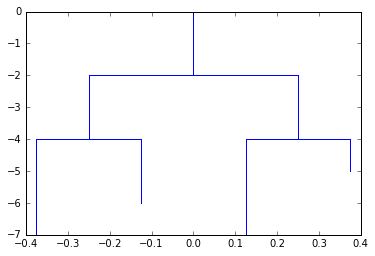

In [484]:
node.plot(1, 0)

In [485]:
def prepare_snp_data(genomes):
    data = set(map(frozenset, [[-1]+g for g in genomes]))
    all_snps = Counter()
    [all_snps.update(data_) for data_ in data]
    return data, all_snps

In [486]:
nc = name_creator()
data = [
    [],
    [],
    [10, 20],
    [10, 30]
]
from collections import Counter
data, all_snps = prepare_snp_data(data)
name_mapper = dict(zip(data, string.ascii_letters))
print(all_snps)
node = Node(data, all_snps.most_common())
print('unresolved:',node)
node.resolve()
node.assign_names(name_mapper)
print('resolved:',node)

Counter({-1: 3, 10: 2, 20: 1, 30: 1})
('unresolved:', set([frozenset([-1]), frozenset([10, 20, -1]), frozenset([10, 30, -1])]):0)
('resolved:', ((b:1,c:1):1,a:0):1)


In [487]:
name_mapper

{frozenset({-1}): 'a',
 frozenset({-1, 10, 20}): 'b',
 frozenset({-1, 10, 30}): 'c'}

In [489]:
from analysis.BaseObjects import Genotype
data = [Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=53945944, parent_genotype=39442523, n_resistant=0, n_driver=4, frequency=6, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 6083252, 6549724, 14298029, 15880390, 26148268, 31106045, 35963989, 39639710, 54215311]),
 Genotype(original_id=48313940, parent_genotype=37731118, n_resistant=0, n_driver=4, frequency=12, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 26968080, 30030918, 31601076, 37919698, 48555266]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=53768008, parent_genotype=40438090, n_resistant=0, n_driver=4, frequency=7, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10296027, 11312617, 13224537, 18996637, 27834907, 31393323, 40640275, 54036483]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=46704426, parent_genotype=23625296, n_resistant=0, n_driver=4, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 22941044, 23743905, 46937777]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=28440757, parent_genotype=24728175, n_resistant=0, n_driver=4, frequency=31, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303]),
 Genotype(original_id=45708257, parent_genotype=44179318, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 44400037, 45936547]),
 Genotype(original_id=45111329, parent_genotype=37360231, n_resistant=0, n_driver=4, frequency=8, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 37546878, 45336651]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=52294075, parent_genotype=45658571, n_resistant=0, n_driver=3, frequency=3, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 23996111, 32655626, 45886611, 52555285]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=26840592, parent_genotype=26337373, n_resistant=0, n_driver=3, frequency=23, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 5089642, 17798767, 21601937, 25206604, 26469536, 26975288]),
 Genotype(original_id=48313940, parent_genotype=37731118, n_resistant=0, n_driver=4, frequency=12, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 26968080, 30030918, 31601076, 37919698, 48555266]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=64949181, parent_genotype=51480635, n_resistant=0, n_driver=5, frequency=1, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 19722185, 38597502, 1121130704, 48423764, 50444944, 51737766, 65273125]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=46704426, parent_genotype=23625296, n_resistant=0, n_driver=4, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 22941044, 23743905, 46937777]),
 Genotype(original_id=62579300, parent_genotype=51928389, n_resistant=0, n_driver=2, frequency=2, snps=[4, 27, 148, 1073746974, 5225, 15749, 20803, 76499, 86621, 165295, 2983602, 1077202917, 4585103, 6818369, 10875141, 11318726, 12959389, 20742456, 35916880, 39567530, 40856690, 45224609, 52187762, 62891668]),
 Genotype(original_id=48377137, parent_genotype=39558364, n_resistant=0, n_driver=4, frequency=14, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 16392237, 19535028, 30627257, 33022630, 39756105, 48618758]),
 Genotype(original_id=57311168, parent_genotype=46740392, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 148, 1073746974, 5225, 277895, 371253, 1074208017, 563207, 763820, 855732, 2238053, 2501468, 2706675, 1076917357, 3316167, 4222299, 11513641, 13790269, 22725877, 24406868, 27099553, 36077633, 46973905, 57597323]),
 Genotype(original_id=45708257, parent_genotype=44179318, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 44400037, 45936547]),
 Genotype(original_id=61820970, parent_genotype=28440757, n_resistant=0, n_driver=4, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 62129653]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=50283320, parent_genotype=44578196, n_resistant=0, n_driver=4, frequency=6, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10195176, 23039566, 27325455, 44800890, 50534406]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=63194757, parent_genotype=46131876, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 46362351, 63510133]),
 Genotype(original_id=45708257, parent_genotype=44179318, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 44400037, 45936547]),
 Genotype(original_id=29055128, parent_genotype=24589377, n_resistant=0, n_driver=4, frequency=29, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726]),
 Genotype(original_id=61394643, parent_genotype=48313940, n_resistant=0, n_driver=4, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 26968080, 30030918, 31601076, 37919698, 48555266, 61701179]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=58982653, parent_genotype=27905453, n_resistant=0, n_driver=4, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 15957640, 18128137, 28045370, 59277089]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=61820970, parent_genotype=28440757, n_resistant=0, n_driver=4, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 62129653]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=45111329, parent_genotype=37360231, n_resistant=0, n_driver=4, frequency=8, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 37546878, 45336651]),
 Genotype(original_id=45111329, parent_genotype=37360231, n_resistant=0, n_driver=4, frequency=8, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 37546878, 45336651]),
 Genotype(original_id=48376487, parent_genotype=47779419, n_resistant=0, n_driver=4, frequency=43, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 15957640, 18128137, 29211928, 48018058, 48618103]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=58579609, parent_genotype=24236880, n_resistant=0, n_driver=3, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 6389576, 8659404, 11508997, 15062527, 20627586, 24358542, 58872054]),
 Genotype(original_id=48376487, parent_genotype=47779419, n_resistant=0, n_driver=4, frequency=43, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 15957640, 18128137, 29211928, 48018058, 48618103]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=48313940, parent_genotype=37731118, n_resistant=0, n_driver=4, frequency=12, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 26968080, 30030918, 31601076, 37919698, 48555266]),
 Genotype(original_id=53768008, parent_genotype=40438090, n_resistant=0, n_driver=4, frequency=7, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10296027, 11312617, 13224537, 18996637, 27834907, 31393323, 40640275, 54036483]),
 Genotype(original_id=45111329, parent_genotype=37360231, n_resistant=0, n_driver=4, frequency=8, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 37546878, 45336651]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=51928389, parent_genotype=44999863, n_resistant=0, n_driver=2, frequency=7, snps=[4, 27, 148, 1073746974, 5225, 15749, 20803, 76499, 86621, 165295, 2983602, 1077202917, 4585103, 6818369, 10875141, 11318726, 12959389, 20742456, 35916880, 39567530, 40856690, 45224609, 52187762]),
 Genotype(original_id=48376487, parent_genotype=47779419, n_resistant=0, n_driver=4, frequency=43, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 15957640, 18128137, 29211928, 48018058, 48618103]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=57393415, parent_genotype=55844578, n_resistant=0, n_driver=4, frequency=7, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 22842615, 24852322, 28583303, 44400037, 45936547, 53022890, 56123500, 57679978]),
 Genotype(original_id=48765532, parent_genotype=42350167, n_resistant=0, n_driver=3, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 2492967, 8893975, 10429537, 11795250, 13618047, 18209223, 20359894, 24510528, 31618846, 35359266, 42561775, 49009149]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=46704426, parent_genotype=23625296, n_resistant=0, n_driver=4, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 22941044, 23743905, 46937777]),
 Genotype(original_id=60980319, parent_genotype=56005338, n_resistant=0, n_driver=2, frequency=2, snps=[4, 27, 148, 1073746974, 5225, 15749, 20803, 76499, 86621, 165295, 2983602, 1077202917, 4585103, 14365430, 14845398, 14845399, 20199718, 20348122, 22574107, 34665390, 49476019, 56285011, 61284730]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=50283320, parent_genotype=44578196, n_resistant=0, n_driver=4, frequency=6, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10195176, 23039566, 27325455, 44800890, 50534406]),
 Genotype(original_id=65203132, parent_genotype=63108062, n_resistant=0, n_driver=3, frequency=1, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 23996111, 32655626, 45886611, 52555285, 55579146, 63423015, 65528348]),
 Genotype(original_id=63194757, parent_genotype=46131876, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 46362351, 63510133]),
 Genotype(original_id=53945944, parent_genotype=39442523, n_resistant=0, n_driver=4, frequency=6, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 6083252, 6549724, 14298029, 15880390, 26148268, 31106045, 35963989, 39639710, 54215311]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=63108062, parent_genotype=55302994, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 23996111, 32655626, 45886611, 52555285, 55579146, 63423015]),
 Genotype(original_id=47736264, parent_genotype=42535664, n_resistant=0, n_driver=4, frequency=18, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 42748229, 47974704]),
 Genotype(original_id=59031678, parent_genotype=52248796, n_resistant=0, n_driver=4, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 46496324, 52509798, 59326347]),
 Genotype(original_id=51480635, parent_genotype=50194315, n_resistant=0, n_driver=5, frequency=8, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 19722185, 38597502, 1121130704, 48423764, 50444944, 51737766]),
 Genotype(original_id=64472163, parent_genotype=50283320, n_resistant=0, n_driver=4, frequency=4, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10195176, 23039566, 27325455, 44800890, 50534406, 64793783]),
 Genotype(original_id=48376487, parent_genotype=47779419, n_resistant=0, n_driver=4, frequency=43, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 15957640, 18128137, 29211928, 48018058, 48618103]),
 Genotype(original_id=40619771, parent_genotype=33958839, n_resistant=0, n_driver=4, frequency=12, snps=[4, 27, 148, 1073746974, 5225, 277895, 371253, 1074208017, 2179386, 2348866, 1076354539, 1080333122, 19081773, 19258391, 34128577, 40822855]),
 Genotype(original_id=52713149, parent_genotype=51755172, n_resistant=0, n_driver=4, frequency=20, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 25205887, 27359428, 36901313, 48092392, 52013695, 52976474]),
 Genotype(original_id=35431417, parent_genotype=7053732, n_resistant=0, n_driver=3, frequency=14, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 2492967, 2967939, 7089264, 35608537]),
 Genotype(original_id=47032322, parent_genotype=43675829, n_resistant=0, n_driver=4, frequency=9, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=55586845, parent_genotype=45111329, n_resistant=0, n_driver=4, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 17016265, 24712831, 29200726, 37546878, 45336651, 55864452]),
 Genotype(original_id=60195634, parent_genotype=59158017, n_resistant=0, n_driver=4, frequency=5, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 26582331, 27555068, 45719372, 59453354, 60496175]),
 Genotype(original_id=52668024, parent_genotype=20202605, n_resistant=0, n_driver=4, frequency=1, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9569408, 11336728, 14399081, 18586050, 20303891, 52931125]),
 Genotype(original_id=22620793, parent_genotype=15744488, n_resistant=0, n_driver=3, frequency=62, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 2389336, 2646300, 3940073, 6713363, 8773754, 11494170, 15823542, 22734381]),
 Genotype(original_id=51928389, parent_genotype=44999863, n_resistant=0, n_driver=2, frequency=7, snps=[4, 27, 148, 1073746974, 5225, 15749, 20803, 76499, 86621, 165295, 2983602, 1077202917, 4585103, 6818369, 10875141, 11318726, 12959389, 20742456, 35916880, 39567530, 40856690, 45224609, 52187762]),
 Genotype(original_id=34528295, parent_genotype=28326366, n_resistant=0, n_driver=4, frequency=22, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 7514194, 8350071, 9402366, 16277916, 17657465, 24330294, 28468309, 34700971]),
 Genotype(original_id=63722134, parent_genotype=47032322, n_resistant=0, n_driver=4, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 10543003, 12941179, 23052266, 37056792, 43894039, 47267188, 64040133]),
 Genotype(original_id=53768008, parent_genotype=40438090, n_resistant=0, n_driver=4, frequency=7, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10296027, 11312617, 13224537, 18996637, 27834907, 31393323, 40640275, 54036483]),
 Genotype(original_id=35566780, parent_genotype=27246836, n_resistant=0, n_driver=4, frequency=25, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 27383525, 35744570]),
 Genotype(original_id=58139036, parent_genotype=49617133, n_resistant=0, n_driver=3, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 2389336, 2646300, 3940073, 6713363, 8773754, 11494170, 15823542, 22734381, 49864977, 58429365]),
 Genotype(original_id=64802373, parent_genotype=53845154, n_resistant=0, n_driver=4, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013, 65125611]),
 Genotype(original_id=58882176, parent_genotype=35123436, n_resistant=0, n_driver=3, frequency=1, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 2492967, 2967939, 6930259, 7960774, 9201309, 11047065, 15928714, 35299099, 59176118]),
 Genotype(original_id=53845154, parent_genotype=40518068, n_resistant=0, n_driver=4, frequency=17, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013]),
 Genotype(original_id=53220329, parent_genotype=51775483, n_resistant=0, n_driver=3, frequency=34, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 42112602, 46798464, 52034096, 53486155]),
 Genotype(original_id=26641323, parent_genotype=13923230, n_resistant=0, n_driver=4, frequency=10, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 8211898, 9854080, 11633647, 13993127, 26775014]),
 Genotype(original_id=55302994, parent_genotype=52294075, n_resistant=0, n_driver=3, frequency=16, snps=[4, 27, 557, 1073752248, 1073841758, 333720, 408786, 888387, 1068022, 1076404877, 3150956, 3978150, 4716665, 6686928, 8954553, 12550797, 17585250, 23996111, 32655626, 45886611, 52555285, 55579146]),
 Genotype(original_id=64802373, parent_genotype=53845154, n_resistant=0, n_driver=4, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 9754645, 14585606, 18435099, 20969877, 33452850, 35689987, 40720641, 54114013, 65125611]),
 Genotype(original_id=60359441, parent_genotype=46023333, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1902176, 2000973, 5586788, 8175003, 11636402, 33255535, 46253269, 60660764]),
 Genotype(original_id=52637564, parent_genotype=44103502, n_resistant=0, n_driver=4, frequency=5, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 5385652, 5789893, 8211335, 10195176, 24838648, 26095939, 29140117, 30577126, 31427797, 34256268, 38876579, 44323849, 52900529]),
 Genotype(original_id=40527770, parent_genotype=36590890, n_resistant=0, n_driver=3, frequency=3, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 2492967, 2967939, 6233245, 17879610, 18112004, 18461868, 36773785, 40730398]),
 Genotype(original_id=60623099, parent_genotype=52376949, n_resistant=0, n_driver=4, frequency=4, snps=[4, 27, 96, 396, 1073742265, 1040, 1072, 2048, 14259, 19833, 175121, 570276, 1074462802, 1075017413, 1727579, 1077683539, 4961114, 9864679, 13407102, 14362975, 18186139, 20857103, 28530626, 32447248, 36213190, 43110286, 52638555, 60925712]),
 Genotype(original_id=57311168, parent_genotype=46740392, n_resistant=0, n_driver=3, frequency=2, snps=[4, 27, 148, 1073746974, 5225, 277895, 371253, 1074208017, 563207, 763820, 855732, 2238053, 2501468, 2706675, 1076917357, 3316167, 4222299, 11513641, 13790269, 22725877, 24406868, 27099553, 36077633, 46973905, 57597323])]

In [492]:
data_extracted = [data_.snps for data_ in data]

In [493]:
def number_yielder():
    i = 0
    while True:
        yield str(i)
        i+=1

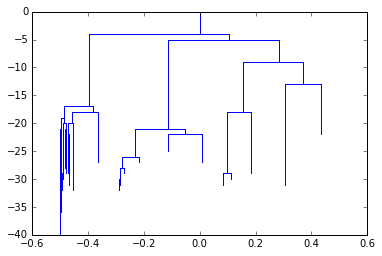

In [496]:
from collections import Counter
data, all_snps = prepare_snp_data(data_extracted)
name_mapper = dict(zip(data, number_yielder()))
node = Node(data, all_snps.most_common())
# print('unresolved:',node)
node.resolve()
node.assign_names(name_mapper)
node.plot(1, 0)

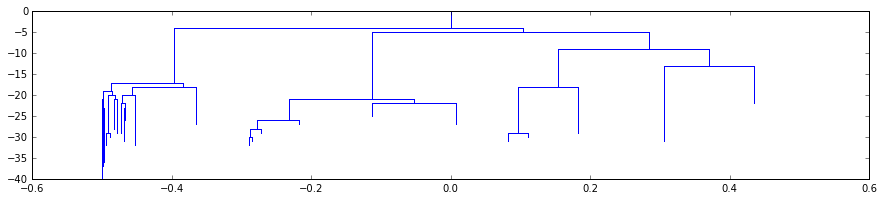

In [505]:
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
node.plot(1, 0,ax=ax)